# Capital Ratios
## 1. Market and Book Capital ratios

In [1]:
import pandas as pd
import numpy as np

In [2]:
ticks = pd.read_csv ('../data/manual/ticks_v2.csv', sep="|")
ticks['gvkey'] = ticks['gvkey'].fillna(0.0).astype(int)
ticks['Permco'] = ticks['Permco'].fillna(0.0).astype(int)
ticks.head(10)

,Primary Dealer,Holding Company,Ticker,Start Date,End Date,Permco,gvkey
0,"ABN AMRO BANK, N.V., NY BR",BAC NORTH AMERICA HOLDING COMPANY,NaN,9/29/98,9/15/06,31989,15504
1,AUBREY G. LANSTON & CO.,"INDUSTRIAL BANK OF JAPAN, LIMITED",8302 (Japan),5/19/60,4/17/00,0,15685
2,"BA SECURITIES, INC.",Bank of America Corporation,BAC (NYSE),4/18/94,9/30/97,437,7647
3,BANC OF AMERICA SECURITIES LLC,Bank of America Corporation,BAC (NYSE),5/17/99,11/1/10,3151,7647
4,"BANC ONE CAPITAL MARKETS, INC",JPMorgan Chase & Co. (Acquired by JPMorgan Chase),JPM (NYSE),4/1/99,8/1/04,20436,2968
5,BANCAMERICA ROBERTSON STEPHEN,BANKBOSTON CORP,BKB.2,10/1/97,9/30/98,20264,2014
6,BANK OF AMERICA NT & SA,Bank of America Corporation,BAC (NYSE),11/17/71,4/15/94,437,7647
7,"BANK OF NOVA SCOTIA, NEW YORK AGENCY",BANK OF NOVA SCOTIA,BNS (Toronto),10/4/11,Current,43264,15582
8,BANKERS TRUST,Bankers Trust New York Corporation,NaN,5/19/60,7/7/89,20266,2029
9,BARCLAYS CAPITAL INC.,Barclays PLC,BARC (LSE),4/1/98,Current,20269,12673


In [3]:
import pandas as pd
import wrds
import config
from datetime import datetime

db = wrds.Connection(wrds_username=config.WRDS_USERNAME)

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [4]:
# Function to convert date to quarter format 'YYYYQ#'
def date_to_quarter(date):
    year = date.year
    quarter = (date.month - 1) // 3 + 1
    return f"{year}Q{quarter}"

# Function to convert quarter 'YYYYQ#' to date format
def quarter_to_date(quarter):
    year = int(quarter[:4])
    quarter = int(quarter[-1])
    month = quarter * 3 
    return datetime(year, month, 1) + pd.DateOffset(months=1) - pd.DateOffset(days=1)


In [5]:
def fetch_financial_data_quarterly(pgvkey, start_date, end_date):
    """
    Fetch financial data for a given ticker and date range from the CCM database in WRDS.
    
    :param gvkey: The gvkey symbol for the company.
    :param start_date: The start date for the data in YYYY-MM-DD format.
    :param end_date: The end date for the data in YYYY-MM-DD format or 'Current'.
    :return: A DataFrame containing the financial data.
    """
    if not gvkey:  # Skip if no ticker is available
        return pd.DataFrame()
    
    # Convert 'Current' to today's date if necessary
    if end_date == 'Current':
        end_date = datetime.today().strftime('%Y-%m-%d')
    
    # Convert start and end dates to datetime objects
    start_date_dt = pd.to_datetime(start_date)
    end_date_dt = pd.to_datetime(end_date)
    
    # Format start and end quarters
    start_qtr = date_to_quarter(start_date_dt)
    end_qtr = date_to_quarter(end_date_dt)

    query = f"""
    SELECT datafqtr, atq AS total_assets, ltq AS book_debt, 
            COALESCE(teqq, ceqq + COALESCE(pstkq, 0) + COALESCE(mibnq, 0)) AS book_equity, 
            cshoq*prccq AS market_equity, gvkey, conm
    FROM comp.fundq as cst
    WHERE cst.gvkey = '{str(pgvkey).zfill(6)}'
    AND cst.datafqtr BETWEEN '{start_qtr}' AND '{end_qtr}'
    AND indfmt='INDL'
    AND datafmt='STD'
    AND popsrc='D'
    AND consol='C'
    """
    data = db.raw_sql(query)
    return data

In [6]:
ticks.loc[ticks['End Date'] == 'Current', 'End Date'] = datetime.today().strftime('%Y-%m-%d')

# Convert start and end dates to datetime objects
ticks['Start Date'] = pd.to_datetime(ticks['Start Date'])
ticks['End Date'] = pd.to_datetime(ticks['End Date'])
ticks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Primary Dealer   111 non-null    object        
 1   Holding Company  102 non-null    object        
 2   Ticker           82 non-null     object        
 3   Start Date       111 non-null    datetime64[ns]
 4   End Date         111 non-null    datetime64[ns]
 5   Permco           111 non-null    int64         
 6   gvkey            111 non-null    int64         
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 6.2+ KB


/var/folders/hk/t7fnwnf568g5fqkjmc9d2vbr0000gn/T/ipykernel_51877/4195261841.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ticks['Start Date'] = pd.to_datetime(ticks['Start Date'])
/var/folders/hk/t7fnwnf568g5fqkjmc9d2vbr0000gn/T/ipykernel_51877/4195261841.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ticks['End Date'] = pd.to_datetime(ticks['End Date'])


In [7]:
# def merge_overlapping_periods(group):
#     merged_periods = []
#     group = group.reset_index(drop=True)
#     current_start = group.at[0, 'Start Date']
#     current_end = group.at[0, 'End Date']

#     for i in range(1, len(group)):
#         start, end = group.at[i, 'Start Date'], group.at[i, 'End Date']
#         if start <= current_end:
#             current_end = max(current_end, end)
#         else:
#             merged_periods.append((current_start, current_end))
#             current_start, current_end = start, end
#     merged_periods.append((current_start, current_end))
    
#     return pd.DataFrame(merged_periods, columns=['Start Date', 'End Date'])

# # Sort and apply the merging function
# ticks.sort_values(by=['gvkey', 'Start Date'], inplace=True)
# cleaned_ticks = ticks.groupby('gvkey').apply(merge_overlapping_periods).reset_index()

# # Clean up the DataFrame
# cleaned_ticks.drop(columns='level_1', inplace=True)
# cleaned_ticks

Get all data for primary dealers

In [8]:
empty_tickers = []
prim_dealers = pd.DataFrame()

# Iterate over DataFrame rows and fetch data for each ticker
for index, row in ticks.iterrows():
    gvkey = row['gvkey']
    start_date = row['Start Date']
    end_date = row['End Date']     # Formatting date for the query
    
    # Fetch financial data for the ticker if available
    new_data = fetch_financial_data_quarterly(gvkey, start_date, end_date)
    if isinstance(new_data, tuple):
        empty_tickers.append({row['Ticker']:gvkey})
    else:
        prim_dealers = pd.concat([new_data, prim_dealers], axis=0)
print(empty_tickers)

/var/folders/hk/t7fnwnf568g5fqkjmc9d2vbr0000gn/T/ipykernel_51877/2578673110.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  prim_dealers = pd.concat([new_data, prim_dealers], axis=0)
/var/folders/hk/t7fnwnf568g5fqkjmc9d2vbr0000gn/T/ipykernel_51877/2578673110.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  prim_dealers = pd.concat([new_data, prim_dealers], axis=0)
/var/folders/hk/t7fnwnf568g5fqkjmc9d2vbr0000gn/T/ipykernel_51877/2578673110.py:15: FutureWarning: The behavior of DataFrame 

[]


Get data from all firms in Compustat

In [9]:
prim_dealers = prim_dealers.drop_duplicates()
prim_dealers['datafqtr'] = prim_dealers['datafqtr'].apply(quarter_to_date)
prim_dealers

,datafqtr,total_assets,book_debt,book_equity,market_equity,gvkey,conm
0,1993-09-30,53855.500,50158.000,3697.500,8450.487500,008007,WELLS FARGO & CO
1,1993-12-31,54665.000,50904.098,3760.900,7490.413125,008007,WELLS FARGO & CO
2,1994-03-31,55328.199,51474.898,3853.300,7518.237500,008007,WELLS FARGO & CO
3,1994-06-30,55756.797,51920.199,3836.600,8241.314125,008007,WELLS FARGO & CO
4,1994-09-30,56565.398,52741.098,3824.300,7746.898500,008007,WELLS FARGO & CO
...,...,...,...,...,...,...,...
28,2005-09-30,1084338.560,1056726.945,25221.719,45031.200000,015504,ABN-AMRO HOLDINGS NV
29,2005-12-31,1043048.097,1014447.298,26314.109,49088.828800,015504,ABN-AMRO HOLDINGS NV
30,2006-03-31,1183661.751,1152907.595,28293.581,56132.568000,015504,ABN-AMRO HOLDINGS NV
31,2006-06-30,1260032.402,1228193.523,29329.083,51765.120000,015504,ABN-AMRO HOLDINGS NV


## $\star$ $\star$ Issue: The quarterly data starts from 1974, not 1970..?

In [10]:
# sort prim_dealers by datefqtr
prim_dealers = prim_dealers.sort_values(by=['datafqtr', 'gvkey'])
prim_dealers

,datafqtr,total_assets,book_debt,book_equity,market_equity,gvkey,conm
0,1974-03-31,6085.566,5767.922,268.980,493.506000,004732,FIRST PENNSYLVANIA CORP
1,1974-06-30,6898.445,6574.219,275.114,275.457000,004732,FIRST PENNSYLVANIA CORP
2,1974-09-30,7003.039,6672.891,280.384,163.962500,004732,FIRST PENNSYLVANIA CORP
3,1974-12-31,6883.340,6545.727,284.211,178.719125,004732,FIRST PENNSYLVANIA CORP
0,1974-12-31,348.955,290.383,58.572,11.345367,008299,PAINE WEBBER GROUP
...,...,...,...,...,...,...,...
95,2023-12-31,1717569.000,1629753.000,87816.000,99153.588600,144496,UBS GROUP AG
49,2024-03-31,1324762.000,1247483.000,77279.000,91859.970320,015580,BANK OF MONTREAL
49,2024-03-31,1392886.000,1312434.000,80452.000,76835.124490,015582,BANK OF NOVA SCOTIA
58,2024-03-31,1974405.000,1857917.000,116488.000,184777.400970,015633,ROYAL BANK OF CANADA


In [11]:
# list of unique conm  in prim_dealers
conm = prim_dealers['conm'].unique()
conm

array(['FIRST PENNSYLVANIA CORP', 'PAINE WEBBER GROUP',
       'HUTTON (E.F.) GROUP', 'JPMORGAN CHASE & CO', 'DRESDNER BANK AG',
       'BANKBOSTON CORP', 'CALIFORNIA FED BANCORP INC',
       'MANUFACTURERS HANOVER CORP', 'MORGAN STANLEY',
       'SECURITY PACIFIC CORP', 'ROTHSCHILD (LF) HOLDINGS INC',
       'WESTPAC BANKING CORP', 'BANK OF NEW YORK MELLON CORP',
       'GREENWICH FINANCIAL CORP', 'BANKERS CORP', 'BARCLAYS PLC',
       'DEUTSCHE BANK AG', 'LEHMAN BROTHERS HOLDINGS INC',
       'BANK OF AMERICA CORP', 'WELLS FARGO & CO',
       'SMITH BARNEY HOLDINGS INC', 'BANK OF MONTREAL',
       'CANADIAN IMPERIAL BANK', 'HSBC HLDGS PLC', 'ABN-AMRO HOLDINGS NV',
       'NOMURA HOLDINGS INC', 'PRUDENTIAL FINANCIAL INC',
       'SOCIETE GENERALE GROUP', 'CREDIT SUISSE GROUP', 'UBS GROUP AG',
       'BNP PARIBAS', 'MIZUHO FINANCIAL GROUP INC', 'BGC GROUP INC',
       'JEFFERIES FINANCIAL GRP INC', 'NATWEST GROUP PLC',
       'ROYAL BANK OF CANADA', 'MERRILL LYNCH & CO INC',
       'MF

In [12]:
quarterly_sum_pd = prim_dealers.groupby('datafqtr').agg({
    'total_assets': 'sum',
    'book_debt': 'sum',
    'book_equity': 'sum',
    'market_equity': 'sum'
}).reset_index()
quarterly_sum_pd

,datafqtr,total_assets,book_debt,book_equity,market_equity
0,1974-03-31,6.085566e+03,5.767922e+03,268.980,4.935060e+02
1,1974-06-30,6.898445e+03,6.574219e+03,275.114,2.754570e+02
2,1974-09-30,7.003039e+03,6.672891e+03,280.384,1.639625e+02
3,1974-12-31,7.232295e+03,6.836110e+03,342.783,1.900645e+02
4,1975-03-31,6.929586e+03,6.633207e+03,357.462,2.543723e+02
...,...,...,...,...,...
196,2023-03-31,2.328245e+07,2.195720e+07,1259089.368,1.121567e+06
197,2023-06-30,2.355165e+07,2.225541e+07,1231618.326,1.109979e+06
198,2023-09-30,2.350248e+07,2.221975e+07,1212190.832,1.118444e+06
199,2023-12-31,2.147392e+07,1.888140e+07,1142311.538,1.036197e+06


In [13]:
quarterly_sum_pd = quarterly_sum_pd[quarterly_sum_pd['datafqtr'] >= '1970-01-01']
quarterly_sum_pd = quarterly_sum_pd[quarterly_sum_pd['datafqtr'] <= '2012-12-31']
quarterly_sum_pd

,datafqtr,total_assets,book_debt,book_equity,market_equity
0,1974-03-31,6.085566e+03,5.767922e+03,268.980,493.506000
1,1974-06-30,6.898445e+03,6.574219e+03,275.114,275.457000
2,1974-09-30,7.003039e+03,6.672891e+03,280.384,163.962500
3,1974-12-31,7.232295e+03,6.836110e+03,342.783,190.064492
4,1975-03-31,6.929586e+03,6.633207e+03,357.462,254.372350
...,...,...,...,...,...
151,2011-12-31,2.240932e+07,2.132477e+07,997581.077,630737.068993
152,2012-03-31,1.778051e+07,1.689202e+07,805427.620,735058.686515
153,2012-06-30,2.285767e+07,2.175228e+07,1018410.816,664543.934157
154,2012-09-30,2.291948e+07,2.180190e+07,1032412.870,723588.346354


In [14]:
# check if the sum of book_debt  and book_equity  equals total_assets
((quarterly_sum_pd['book_debt'] + quarterly_sum_pd['book_equity']) / quarterly_sum_pd['total_assets']).mean()

0.9980203300392051

In [15]:
quarterly_sum_pd['market_cap_ratio'] = quarterly_sum_pd['market_equity'] / (quarterly_sum_pd['book_debt'] + quarterly_sum_pd['market_equity'])
quarterly_sum_pd

# standardize market_cap_ratio to zero mean and unit variance
quarterly_sum_pd['market_cap_ratio_std'] = (quarterly_sum_pd['market_cap_ratio'] - quarterly_sum_pd['market_cap_ratio'].mean()) / quarterly_sum_pd['market_cap_ratio'].std()
quarterly_sum_pd

,datafqtr,total_assets,book_debt,book_equity,market_equity,market_cap_ratio,market_cap_ratio_std
0,1974-03-31,6.085566e+03,5.767922e+03,268.980,493.506000,0.078817,1.235593
1,1974-06-30,6.898445e+03,6.574219e+03,275.114,275.457000,0.040215,-0.600697
2,1974-09-30,7.003039e+03,6.672891e+03,280.384,163.962500,0.023982,-1.372867
3,1974-12-31,7.232295e+03,6.836110e+03,342.783,190.064492,0.027051,-1.226887
4,1975-03-31,6.929586e+03,6.633207e+03,357.462,254.372350,0.036932,-0.756847
...,...,...,...,...,...,...,...
151,2011-12-31,2.240932e+07,2.132477e+07,997581.077,630737.068993,0.028728,-1.147111
152,2012-03-31,1.778051e+07,1.689202e+07,805427.620,735058.686515,0.041701,-0.530011
153,2012-06-30,2.285767e+07,2.175228e+07,1018410.816,664543.934157,0.029645,-1.103494
154,2012-09-30,2.291948e+07,2.180190e+07,1032412.870,723588.346354,0.032123,-0.985606


In [16]:
quarterly_sum_pd['book_cap_ratio'] = quarterly_sum_pd['book_equity'] / (quarterly_sum_pd['book_debt'] + quarterly_sum_pd['book_equity'])

# standardize book_cap_ratio to zero mean and unit variance
quarterly_sum_pd['book_cap_ratio_std'] = (quarterly_sum_pd['book_cap_ratio'] - quarterly_sum_pd['book_cap_ratio'].mean()) / quarterly_sum_pd['book_cap_ratio'].std()
quarterly_sum_pd

,datafqtr,total_assets,book_debt,book_equity,market_equity,market_cap_ratio,market_cap_ratio_std,book_cap_ratio,book_cap_ratio_std
0,1974-03-31,6.085566e+03,5.767922e+03,268.980,493.506000,0.078817,1.235593,0.044556,-0.138411
1,1974-06-30,6.898445e+03,6.574219e+03,275.114,275.457000,0.040215,-0.600697,0.040167,-0.991252
2,1974-09-30,7.003039e+03,6.672891e+03,280.384,163.962500,0.023982,-1.372867,0.040324,-0.960654
3,1974-12-31,7.232295e+03,6.836110e+03,342.783,190.064492,0.027051,-1.226887,0.047749,0.481925
4,1975-03-31,6.929586e+03,6.633207e+03,357.462,254.372350,0.036932,-0.756847,0.051134,1.139696
...,...,...,...,...,...,...,...,...,...
151,2011-12-31,2.240932e+07,2.132477e+07,997581.077,630737.068993,0.028728,-1.147111,0.044690,-0.112412
152,2012-03-31,1.778051e+07,1.689202e+07,805427.620,735058.686515,0.041701,-0.530011,0.045511,0.047138
153,2012-06-30,2.285767e+07,2.175228e+07,1018410.816,664543.934157,0.029645,-1.103494,0.044725,-0.105640
154,2012-09-30,2.291948e+07,2.180190e+07,1032412.870,723588.346354,0.032123,-0.985606,0.045213,-0.010709


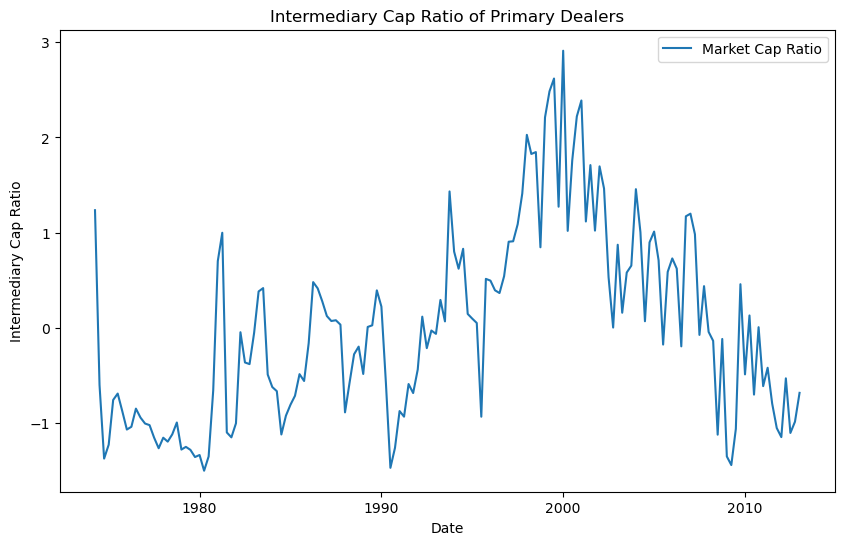

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(quarterly_sum_pd['datafqtr'], quarterly_sum_pd['market_cap_ratio_std'], label='Market Cap Ratio')

ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.set_xlabel('Date')
ax.set_ylabel('Intermediary Cap Ratio')
ax.set_title('Intermediary Cap Ratio of Primary Dealers')
ax.legend()
plt.show()

## 2. AEM Leverage
$$
\text{Leverage}_t = \frac{\text{Total Financial Assets}_t}{\text{Total Financial Assets}_t - \text{Total Liabilities}_t}
$$

$$
\text{Leverage Implied Capital Ratio} = \frac{1}{\text{Leverage}_t}
$$

### 1) First attempt - using the current pulled data 

In [18]:
# import load_fred and pull data from load_fred_macro_data
from load_fred import load_fred_macro_data
macro_data = load_fred_macro_data()

macro_data = macro_data.rename(columns={'UNRATE': 'unemp_rate', 
                                        'NFCI': 'nfci', 
                                        'GDP': 'nom_gdp', 
                                        'GDPC1': 'real_gdp', 
                                        'A191RL1Q225SBEA': 'real_gdp_growth',
                                        'BOGZ1FL664090005Q': 'bd_fin_assets',
                                        'BOGZ1FL664190005Q': 'bd_liabilities',
                                        })
macro_data

,unemp_rate,nfci,nom_gdp,real_gdp,real_gdp_growth,bd_fin_assets,bd_liabilities
DATE,,,,,,,
1970-03-31,4.166667,NaN,1051.200,5300.652,-0.6,13071.0,12089.0
1970-06-30,4.766667,NaN,1067.375,5308.164,0.6,11741.0,10802.0
1970-09-30,5.166667,NaN,1086.059,5357.077,3.7,13298.0,12384.0
1970-12-31,5.833333,NaN,1088.608,5299.672,-4.2,16246.0,15340.0
1971-03-31,5.933333,0.893634,1135.156,5443.619,11.3,14861.0,13923.0
...,...,...,...,...,...,...,...
2023-03-31,3.500000,-0.257934,26813.601,22112.329,2.2,4803777.0,4501526.0
2023-06-30,3.566667,-0.231994,27063.012,22225.350,2.1,4809159.0,4504411.0
2023-09-30,3.700000,-0.329642,27610.128,22490.692,4.9,4757062.0,4449712.0


In [19]:
# calculate leverage 
# the AEM implied capital is the inverse of broker–dealer book leverage from Flow of Funds used in AEM
macro_data['aem_leverage'] = macro_data['bd_fin_assets'] / (macro_data['bd_fin_assets'] - macro_data['bd_liabilities'])
macro_data['aem_leverage_ratio'] = 1 / macro_data['aem_leverage'] 

macro_data

,unemp_rate,nfci,nom_gdp,real_gdp,real_gdp_growth,bd_fin_assets,bd_liabilities,aem_leverage,aem_leverage_ratio
DATE,,,,,,,,,
1970-03-31,4.166667,NaN,1051.200,5300.652,-0.6,13071.0,12089.0,13.310591,0.075128
1970-06-30,4.766667,NaN,1067.375,5308.164,0.6,11741.0,10802.0,12.503727,0.079976
1970-09-30,5.166667,NaN,1086.059,5357.077,3.7,13298.0,12384.0,14.549234,0.068732
1970-12-31,5.833333,NaN,1088.608,5299.672,-4.2,16246.0,15340.0,17.931567,0.055768
1971-03-31,5.933333,0.893634,1135.156,5443.619,11.3,14861.0,13923.0,15.843284,0.063118
...,...,...,...,...,...,...,...,...,...
2023-03-31,3.500000,-0.257934,26813.601,22112.329,2.2,4803777.0,4501526.0,15.893337,0.062919
2023-06-30,3.566667,-0.231994,27063.012,22225.350,2.1,4809159.0,4504411.0,15.780773,0.063368
2023-09-30,3.700000,-0.329642,27610.128,22490.692,4.9,4757062.0,4449712.0,15.477670,0.064609


In [20]:
# set the index as datetime
macro_data.index = pd.to_datetime(macro_data.index)
macro_data

,unemp_rate,nfci,nom_gdp,real_gdp,real_gdp_growth,bd_fin_assets,bd_liabilities,aem_leverage,aem_leverage_ratio
DATE,,,,,,,,,
1970-03-31,4.166667,NaN,1051.200,5300.652,-0.6,13071.0,12089.0,13.310591,0.075128
1970-06-30,4.766667,NaN,1067.375,5308.164,0.6,11741.0,10802.0,12.503727,0.079976
1970-09-30,5.166667,NaN,1086.059,5357.077,3.7,13298.0,12384.0,14.549234,0.068732
1970-12-31,5.833333,NaN,1088.608,5299.672,-4.2,16246.0,15340.0,17.931567,0.055768
1971-03-31,5.933333,0.893634,1135.156,5443.619,11.3,14861.0,13923.0,15.843284,0.063118
...,...,...,...,...,...,...,...,...,...
2023-03-31,3.500000,-0.257934,26813.601,22112.329,2.2,4803777.0,4501526.0,15.893337,0.062919
2023-06-30,3.566667,-0.231994,27063.012,22225.350,2.1,4809159.0,4504411.0,15.780773,0.063368
2023-09-30,3.700000,-0.329642,27610.128,22490.692,4.9,4757062.0,4449712.0,15.477670,0.064609


In [21]:
levels = quarterly_sum_pd[['datafqtr', 'market_cap_ratio', 'book_cap_ratio']].merge(macro_data[['aem_leverage']], left_on='datafqtr', right_index=True)
levels = levels.set_index('datafqtr')
levels

,market_cap_ratio,book_cap_ratio,aem_leverage
datafqtr,,,
1974-03-31,0.078817,0.044556,6.850604
1974-06-30,0.040215,0.040167,6.698759
1974-09-30,0.023982,0.040324,6.250077
1974-12-31,0.027051,0.047749,6.104280
1975-03-31,0.036932,0.051134,5.682123
...,...,...,...
2011-12-31,0.028728,0.044690,23.420368
2012-03-31,0.041701,0.045511,23.163604
2012-06-30,0.029645,0.044725,23.022625


### Results
- The correlation with the capital ratios are different.
- The graph of the AEM leverage ratio is slightly different from the paper's summary slides. 

In [22]:
# get the correlation of capital ratios 
correlation_panelA = levels.corr()
correlation_panelA

,market_cap_ratio,book_cap_ratio,aem_leverage
market_cap_ratio,1.000000,0.20513,0.548297
book_cap_ratio,0.205130,1.00000,-0.104990
aem_leverage,0.548297,-0.10499,1.000000


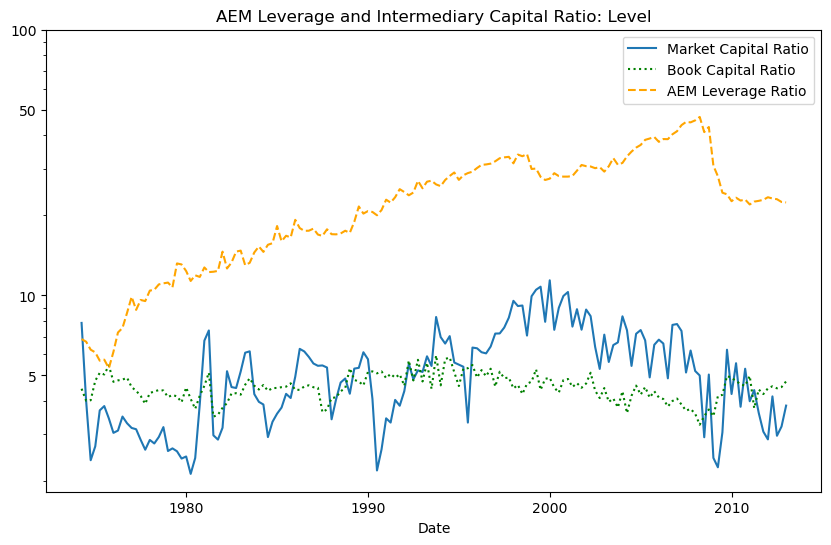

In [23]:
# plot the levels
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(levels.index, levels['market_cap_ratio']*100, label='Market Capital Ratio')
ax.plot(levels.index, levels['book_cap_ratio']*100, label='Book Capital Ratio', color='green', linestyle='dotted')
ax.plot(levels.index, levels['aem_leverage'], label='AEM Leverage Ratio', color='orange', linestyle='--')

ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.set_xlabel('Date')
ax.set_yscale('log')
ax.set_yticks([5, 10, 50, 100])
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter()) 

ax.set_title('AEM Leverage and Intermediary Capital Ratio: Level')
ax.legend(loc='best')
plt.show()


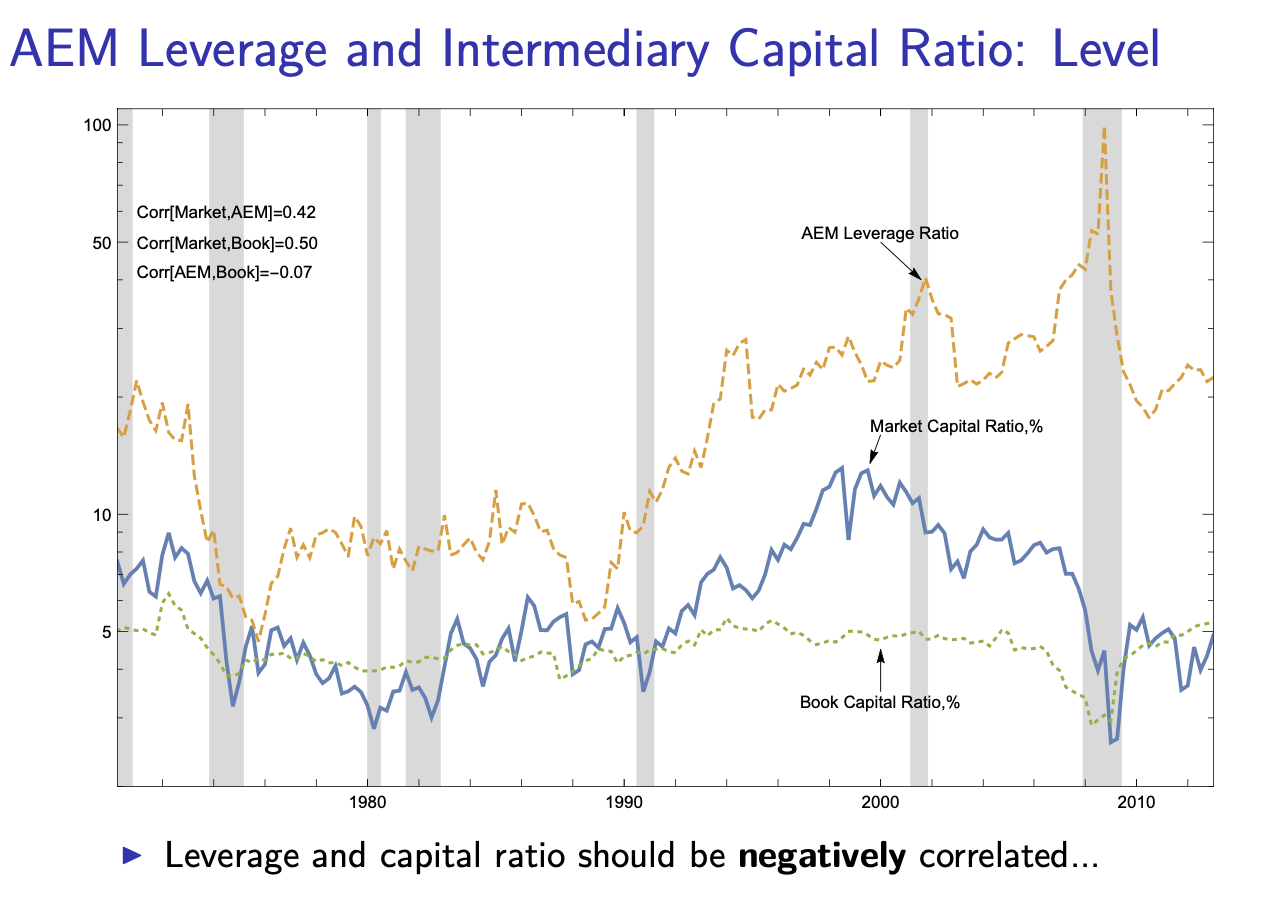

In [24]:
from IPython.display import Image
Image(filename='../data/AEM_level.png', width=800)

### 2) Second attempt - Fetch the historical data
- Total financial assets for the end of 2010.4Q, from the AEM paper, is 2,075.1 billion dollars.
- However, if we pull the current fred dataset, the same item for 2010.4Q is 4,312.8 billion dollars.
- Thus, here I used the past released dataset, which aligns with the AEM paper numbers. 
- link: https://www.federalreserve.gov/releases/z1/20130307/data.htm
    - L.127 Security Brokers and Dealers
    - ltabs.zip (1.3 MB ZIP): Outstandings--unadjusted(in millions of dollars)
- Howeverm the resulting plot is not very different from the first attempt.

In [25]:
fred_bd_data = pd.read_csv('fred_bd_aem.csv', index_col=0)
fred_bd_data.index = fred_bd_data.index.astype(str)
fred_bd_data.index = fred_bd_data.index.str[:4] + 'Q' + fred_bd_data.index.str[5] 

fred_bd_data = fred_bd_data.loc['1969Q4':'2012Q4']
fred_bd_data.index = fred_bd_data.index.to_series().apply(quarter_to_date)
fred_bd_data

,FL664090005.Q,FL663020003.Q,FL664004005.Q,FL663069103.Q,FL663061105.Q,FL663061703.Q,FL663062003.Q,FL663063005.Q,FL663069803.Q,FL663064003.Q,...,FL663170003.Q,FL663167005.Q,FL663167003.Q,FL763067005.Q,FL663178003.Q,FL663190005.Q,FL663192003.Q,FL663194005.Q,FL663193005.Q,Unnamed: 27
DATES,,,,,,,,,,,,,,,,,,,,,
1969-12-31,15402,1386,3670,0,1728,0,361,1581,0,1870,...,580,17200,5655,11545,147,653.0,196.00,0.00,457,NaN
1970-03-31,13071,1322,3436,0,2155,0,557,724,0,1015,...,590,14748,5098,9650,119,644.0,196.00,0.00,448,NaN
1970-06-30,11741,1225,2351,0,620,0,390,1341,0,1633,...,600,13221,4494,8727,108,632.0,194.00,0.00,438,NaN
1970-09-30,13298,1131,3850,0,2007,0,612,1231,0,1522,...,600,14813,4663,10150,135,629.0,192.00,0.00,437,NaN
1970-12-31,16246,1073,6003,0,3398,0,915,1690,0,1982,...,610,17689,4703,12986,150,596.0,169.00,0.00,427,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-31,1949702,111849,563194,42143,183559,147730,30899,104519,54344,103166,...,14262,1073702,752397,189601,131704,2533.0,473255.00,98123.00,1159268,-784136.0
2012-03-31,2063829,117367,610717,43707,203769,148650,34685,149291,30615,116254,...,17316,1107822,762286,190823,154713,2989.0,500165.00,100267.00,1347306,-947408.0
2012-06-30,2052880,105181,600456,34691,201167,169806,31167,130778,32847,113471,...,13480,1165747,777658,209770,178319,2846.0,463581.00,101097.00,1322272,-959788.0


In [26]:
macro_data_2 = pd.DataFrame()
macro_data_2['bd_fin_assets'] = fred_bd_data['FL664090005.Q']
macro_data_2['bd_liabilities'] = fred_bd_data['FL664190005.Q']
macro_data_2['aem_leverage'] =  macro_data_2['bd_fin_assets'] / (macro_data_2['bd_fin_assets'] - macro_data_2['bd_liabilities'])
macro_data_2

,bd_fin_assets,bd_liabilities,aem_leverage
DATES,,,
1969-12-31,15402,14553.00,18.141343
1970-03-31,13071,12285.00,16.629771
1970-06-30,11741,10996.00,15.759732
1970-09-30,13298,12576.00,18.418283
1970-12-31,16246,15509.00,22.043419
...,...,...,...
2011-12-31,1949702,1870911.00,24.745237
2012-03-31,2063829,1978049.00,24.059559
2012-06-30,2052880,1967675.00,24.093422


In [27]:
levels = quarterly_sum_pd[['datafqtr', 'market_cap_ratio', 'book_cap_ratio']].merge(macro_data_2[['aem_leverage']], left_on='datafqtr', right_index=True)
levels = levels.set_index('datafqtr')
levels

,market_cap_ratio,book_cap_ratio,aem_leverage
datafqtr,,,
1974-03-31,0.078817,0.044556,6.602086
1974-06-30,0.040215,0.040167,6.520717
1974-09-30,0.023982,0.040324,6.086532
1974-12-31,0.027051,0.047749,6.165203
1975-03-31,0.036932,0.051134,5.461659
...,...,...,...
2011-12-31,0.028728,0.044690,24.745237
2012-03-31,0.041701,0.045511,24.059559
2012-06-30,0.029645,0.044725,24.093422


In [28]:
# get the correlation of capital ratios 
correlation_panelA = levels.corr()
correlation_panelA

,market_cap_ratio,book_cap_ratio,aem_leverage
market_cap_ratio,1.000000,0.205130,0.489611
book_cap_ratio,0.205130,1.000000,-0.174383
aem_leverage,0.489611,-0.174383,1.000000


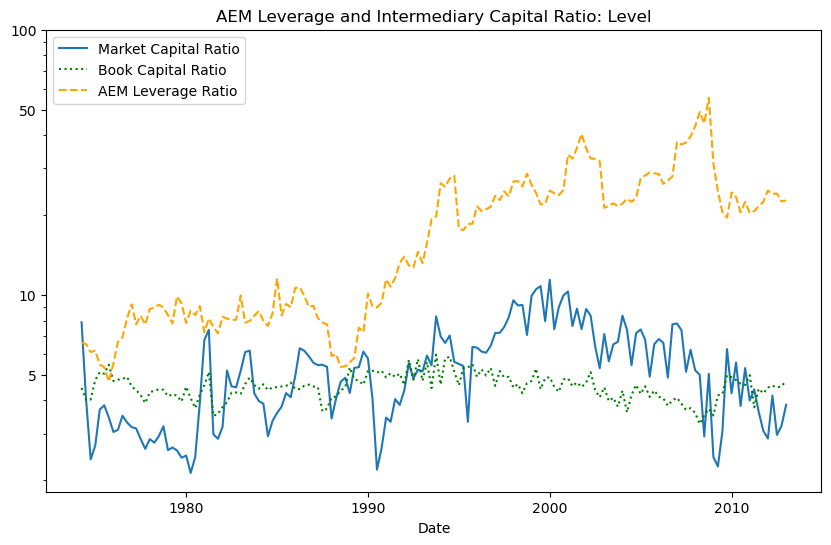

In [29]:
# plot the levels
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(levels.index, levels['market_cap_ratio']*100, label='Market Capital Ratio')
ax.plot(levels.index, levels['book_cap_ratio']*100, label='Book Capital Ratio', color='green', linestyle='dotted')
ax.plot(levels.index, levels['aem_leverage'], label='AEM Leverage Ratio', color='orange', linestyle='--')

ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.set_xlabel('Date')
ax.set_yscale('log')
ax.set_yticks([5, 10, 50, 100])
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter()) 

ax.set_title('AEM Leverage and Intermediary Capital Ratio: Level')
ax.legend(loc='best')
plt.show()


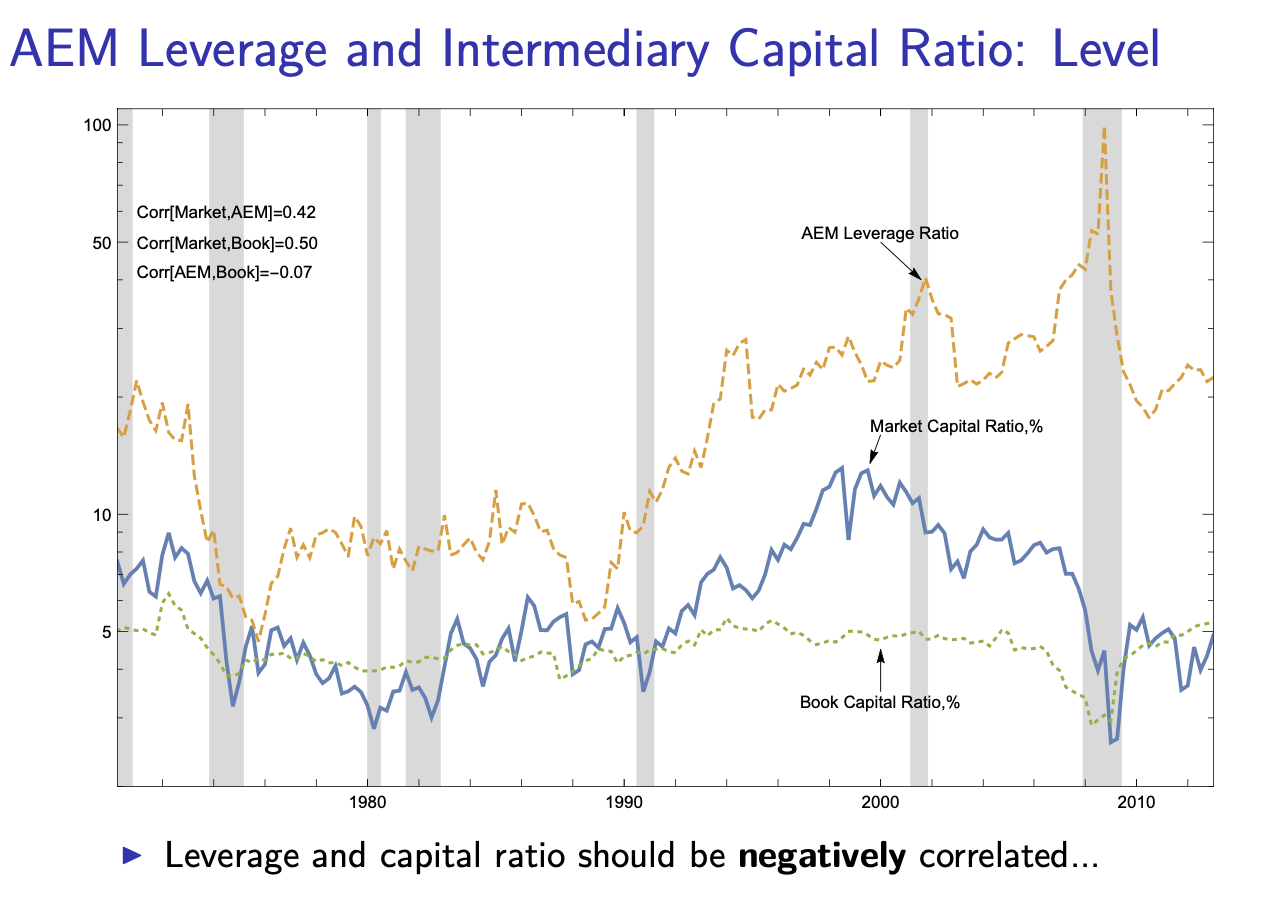

In [30]:
Image(filename='../data/AEM_level.png', width=800)

# Factors

In [31]:
from statsmodels.tsa.ar_model import AutoReg

## $\star$ $\star$ Issue: Is this the right way to calculate factors?

In [32]:
# calculate the market capital factor, AR(1) innovations scaled by the lagged capital ratio 
cleaned_data = quarterly_sum_pd['market_cap_ratio'].dropna()
model = AutoReg(cleaned_data, lags=1)
model_fitted = model.fit()

quarterly_sum_pd['innovations_mkt_cap'] = model_fitted.resid
quarterly_sum_pd['market_capital_factor'] = quarterly_sum_pd['innovations_mkt_cap'] / quarterly_sum_pd['market_cap_ratio'].shift(1)
quarterly_sum_pd = quarterly_sum_pd.drop(columns=['innovations_mkt_cap'])

# standardize capital_risk_factor to zero mean and unit variance
quarterly_sum_pd['market_capital_factor_std'] = (quarterly_sum_pd['market_capital_factor'] - quarterly_sum_pd['market_capital_factor'].mean()) / quarterly_sum_pd['market_capital_factor'].std()

quarterly_sum_pd

,datafqtr,total_assets,book_debt,book_equity,market_equity,market_cap_ratio,market_cap_ratio_std,book_cap_ratio,book_cap_ratio_std,market_capital_factor,market_capital_factor_std
0,1974-03-31,6.085566e+03,5.767922e+03,268.980,493.506000,0.078817,1.235593,0.044556,-0.138411,NaN,NaN
1,1974-06-30,6.898445e+03,6.574219e+03,275.114,275.457000,0.040215,-0.600697,0.040167,-0.991252,-0.421167,-1.714403
2,1974-09-30,7.003039e+03,6.672891e+03,280.384,163.962500,0.023982,-1.372867,0.040324,-0.960654,-0.460081,-1.873726
3,1974-12-31,7.232295e+03,6.836110e+03,342.783,190.064492,0.027051,-1.226887,0.047749,0.481925,-0.101278,-0.404710
4,1975-03-31,6.929586e+03,6.633207e+03,357.462,254.372350,0.036932,-0.756847,0.051134,1.139696,0.184606,0.765762
...,...,...,...,...,...,...,...,...,...,...,...
151,2011-12-31,2.240932e+07,2.132477e+07,997581.077,630737.068993,0.028728,-1.147111,0.044690,-0.112412,-0.200360,-0.810372
152,2012-03-31,1.778051e+07,1.689202e+07,805427.620,735058.686515,0.041701,-0.530011,0.045511,0.047138,0.293050,1.209757
153,2012-06-30,2.285767e+07,2.175228e+07,1018410.816,664543.934157,0.029645,-1.103494,0.044725,-0.105640,-0.336439,-1.367510
154,2012-09-30,2.291948e+07,2.180190e+07,1032412.870,723588.346354,0.032123,-0.985606,0.045213,-0.010709,-0.063866,-0.251534


In [33]:
# calculate the book capital factor, AR(1) innovations scaled by the lagged capital ratio 
cleaned_data = quarterly_sum_pd['book_cap_ratio'].dropna()
model = AutoReg(cleaned_data, lags=1)
model_fitted = model.fit()

quarterly_sum_pd['innovations_book_cap'] = model_fitted.resid
quarterly_sum_pd['book_capital_factor'] = quarterly_sum_pd['innovations_book_cap'] / quarterly_sum_pd['book_cap_ratio'].shift(1)

# standardize capital_risk_factor to zero mean and unit variance
quarterly_sum_pd['book_capital_factor_std'] = (quarterly_sum_pd['book_capital_factor'] - quarterly_sum_pd['book_capital_factor'].mean()) / quarterly_sum_pd['book_capital_factor'].std()

quarterly_sum_pd

,datafqtr,total_assets,book_debt,book_equity,market_equity,market_cap_ratio,market_cap_ratio_std,book_cap_ratio,book_cap_ratio_std,market_capital_factor,market_capital_factor_std,innovations_book_cap,book_capital_factor,book_capital_factor_std
0,1974-03-31,6.085566e+03,5.767922e+03,268.980,493.506000,0.078817,1.235593,0.044556,-0.138411,NaN,NaN,NaN,NaN,NaN
1,1974-06-30,6.898445e+03,6.574219e+03,275.114,275.457000,0.040215,-0.600697,0.040167,-0.991252,-0.421167,-1.714403,-0.004690,-0.105252,-1.158115
2,1974-09-30,7.003039e+03,6.672891e+03,280.384,163.962500,0.023982,-1.372867,0.040324,-0.960654,-0.460081,-1.873726,-0.001911,-0.047587,-0.521030
3,1974-12-31,7.232295e+03,6.836110e+03,342.783,190.064492,0.027051,-1.226887,0.047749,0.481925,-0.101278,-0.404710,0.005419,0.134393,1.489495
4,1975-03-31,6.929586e+03,6.633207e+03,357.462,254.372350,0.036932,-0.756847,0.051134,1.139696,0.184606,0.765762,0.004372,0.091558,1.016248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2011-12-31,2.240932e+07,2.132477e+07,997581.077,630737.068993,0.028728,-1.147111,0.044690,-0.112412,-0.200360,-0.810372,0.001034,0.024299,0.273171
152,2012-03-31,1.778051e+07,1.689202e+07,805427.620,735058.686515,0.041701,-0.530011,0.045511,0.047138,0.293050,1.209757,0.000575,0.012864,0.146842
153,2012-06-30,2.285767e+07,2.175228e+07,1018410.816,664543.934157,0.029645,-1.103494,0.044725,-0.105640,-0.336439,-1.367510,-0.000702,-0.015418,-0.165626
154,2012-09-30,2.291948e+07,2.180190e+07,1032412.870,723588.346354,0.032123,-0.985606,0.045213,-0.010709,-0.063866,-0.251534,0.000256,0.005732,0.068045


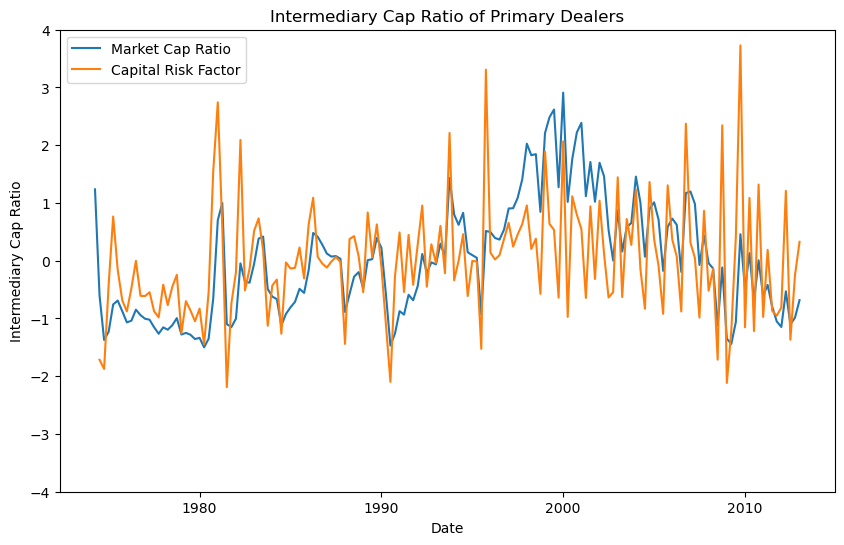

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(quarterly_sum_pd['datafqtr'], quarterly_sum_pd['market_cap_ratio_std'], label='Market Cap Ratio')
ax.plot(quarterly_sum_pd['datafqtr'], quarterly_sum_pd['market_capital_factor_std'], label='Capital Risk Factor')

ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.set_xlabel('Date')
ax.set_ylabel('Intermediary Cap Ratio')
ax.set_ylim(-4, 4)
ax.set_title('Intermediary Cap Ratio of Primary Dealers')
ax.legend()
plt.show()

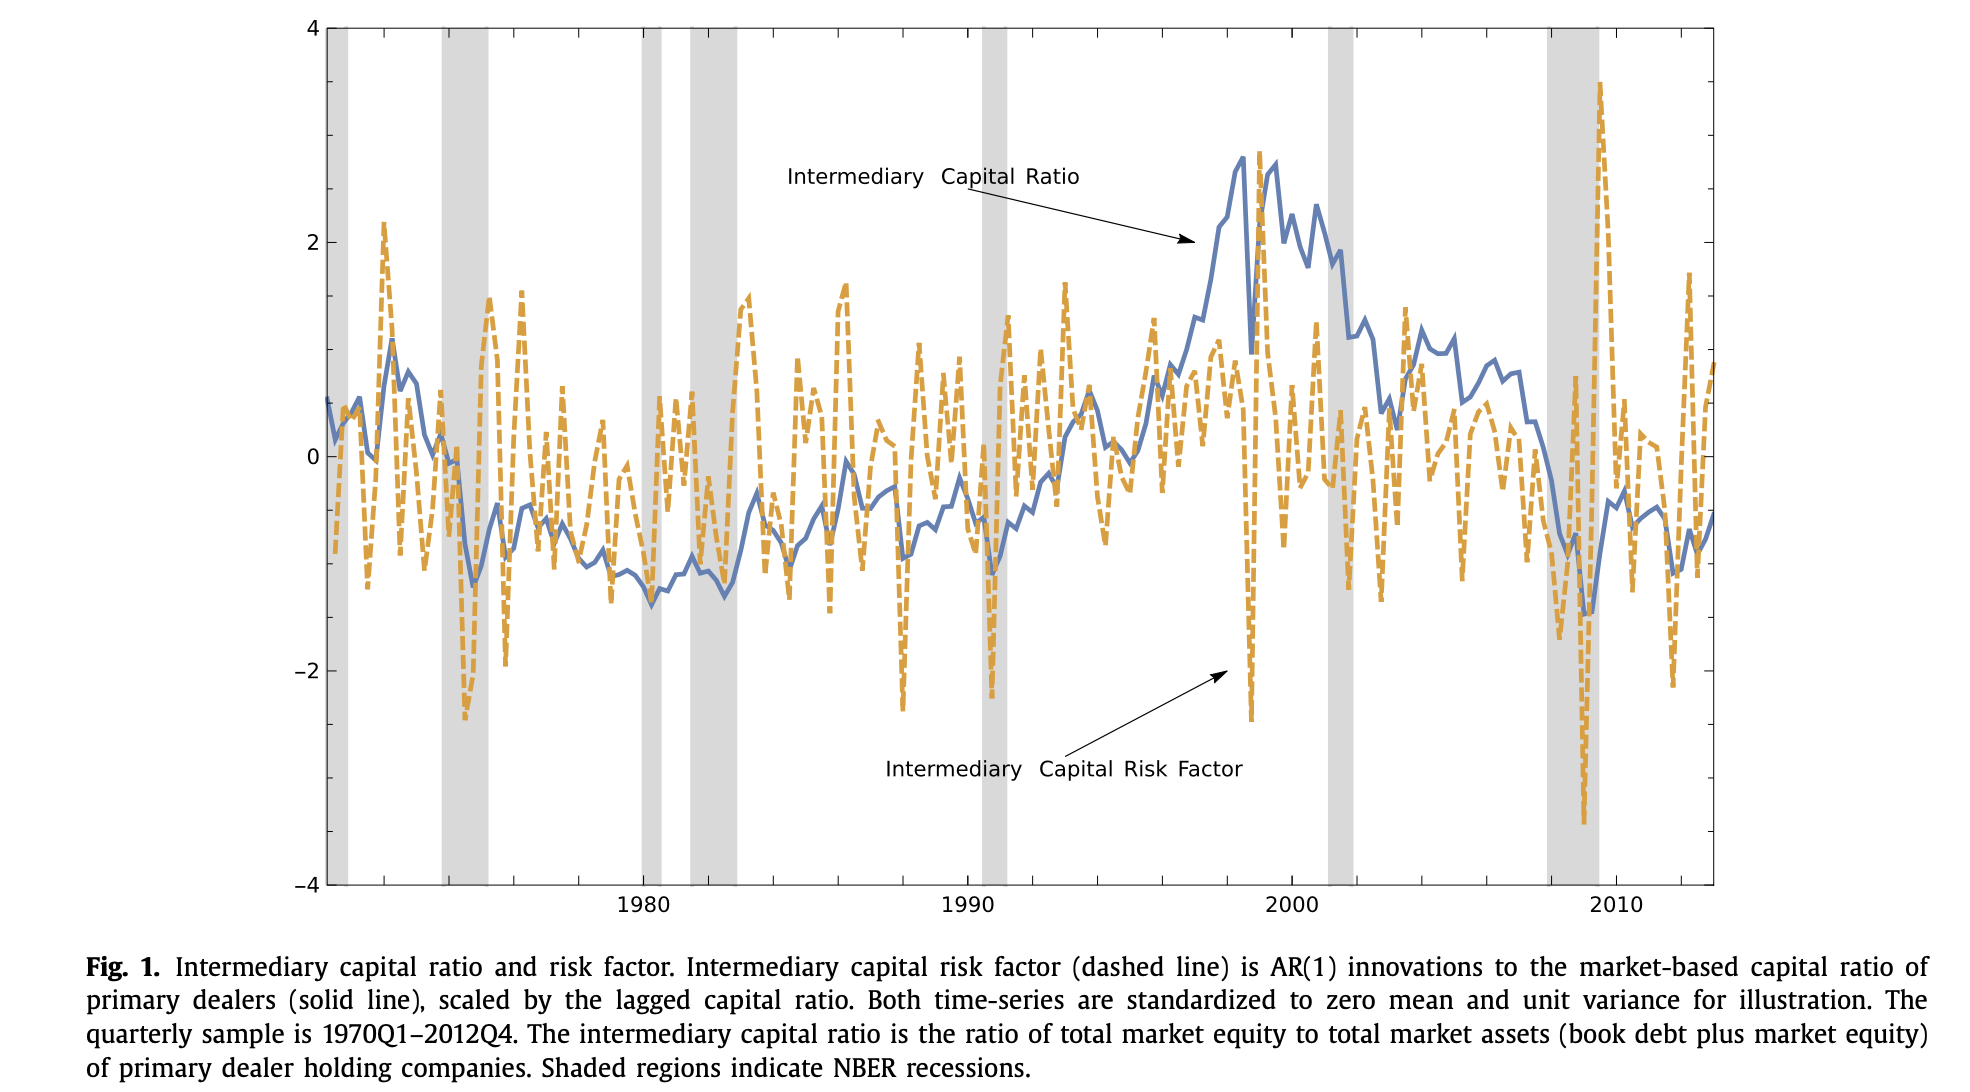

In [35]:
Image(filename='../data/Cap_ratio_factor.png', width=800)

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

# calculate the aem leverage factor, the seasonally adjusted growth rate in broker–dealer book leverage
macro_data['leverage_growth'] = macro_data['aem_leverage'].pct_change()
macro_data['leverage_growth'] = macro_data['leverage_growth'].fillna(0)

decomposition = seasonal_decompose(macro_data['leverage_growth'], model='additive')
macro_data['seasonal'] = decomposition.seasonal

macro_data['aem_leverage_factor'] = macro_data['leverage_growth'] - macro_data['seasonal']
macro_data

/var/folders/hk/t7fnwnf568g5fqkjmc9d2vbr0000gn/T/ipykernel_51877/3016275807.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  macro_data['leverage_growth'] = macro_data['aem_leverage'].pct_change()


,unemp_rate,nfci,nom_gdp,real_gdp,real_gdp_growth,bd_fin_assets,bd_liabilities,aem_leverage,aem_leverage_ratio,leverage_growth,seasonal,aem_leverage_factor
DATE,,,,,,,,,,,,
1970-03-31,4.166667,NaN,1051.200,5300.652,-0.6,13071.0,12089.0,13.310591,0.075128,0.000000,-0.018367,0.018367
1970-06-30,4.766667,NaN,1067.375,5308.164,0.6,11741.0,10802.0,12.503727,0.079976,-0.060618,0.003523,-0.064141
1970-09-30,5.166667,NaN,1086.059,5357.077,3.7,13298.0,12384.0,14.549234,0.068732,0.163592,0.002614,0.160978
1970-12-31,5.833333,NaN,1088.608,5299.672,-4.2,16246.0,15340.0,17.931567,0.055768,0.232475,0.012230,0.220245
1971-03-31,5.933333,0.893634,1135.156,5443.619,11.3,14861.0,13923.0,15.843284,0.063118,-0.116459,-0.018367,-0.098092
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,3.500000,-0.257934,26813.601,22112.329,2.2,4803777.0,4501526.0,15.893337,0.062919,0.054408,-0.018367,0.072774
2023-06-30,3.566667,-0.231994,27063.012,22225.350,2.1,4809159.0,4504411.0,15.780773,0.063368,-0.007082,0.003523,-0.010605
2023-09-30,3.700000,-0.329642,27610.128,22490.692,4.9,4757062.0,4449712.0,15.477670,0.064609,-0.019207,0.002614,-0.021821


In [37]:
factors = quarterly_sum_pd[['datafqtr', 'market_capital_factor', 'book_capital_factor']].merge(macro_data[['aem_leverage_factor']], left_on='datafqtr', right_index=True)
factors = factors.set_index('datafqtr')
factors

,market_capital_factor,book_capital_factor,aem_leverage_factor
datafqtr,,,
1974-03-31,NaN,NaN,-0.219260
1974-06-30,-0.421167,-0.105252,-0.025688
1974-09-30,-0.460081,-0.047587,-0.069594
1974-12-31,-0.101278,0.134393,-0.035557
1975-03-31,0.184606,0.091558,-0.050791
...,...,...,...
2011-12-31,-0.200360,0.024299,0.010416
2012-03-31,0.293050,0.012864,0.007403
2012-06-30,-0.336439,-0.015418,-0.009609


In [38]:
# get the correlation of factors
correlation_panelB = factors.corr()
correlation_panelB

,market_capital_factor,book_capital_factor,aem_leverage_factor
market_capital_factor,1.000000,0.303104,0.027419
book_capital_factor,0.303104,1.000000,0.040450
aem_leverage_factor,0.027419,0.040450,1.000000


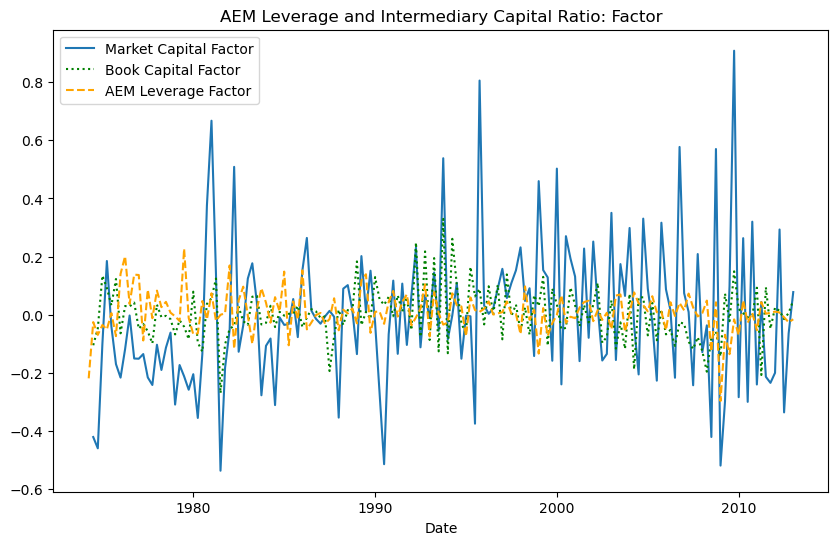

In [39]:
# plot the factors
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(factors.index, factors['market_capital_factor'], label='Market Capital Factor')
ax.plot(factors.index, factors['book_capital_factor'], label='Book Capital Factor', color='green', linestyle='dotted')
ax.plot(factors.index, factors['aem_leverage_factor'], label='AEM Leverage Factor', color='orange', linestyle='--')

ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.set_xlabel('Date')

ax.set_title('AEM Leverage and Intermediary Capital Ratio: Factor')
ax.legend(loc='best')
plt.show()


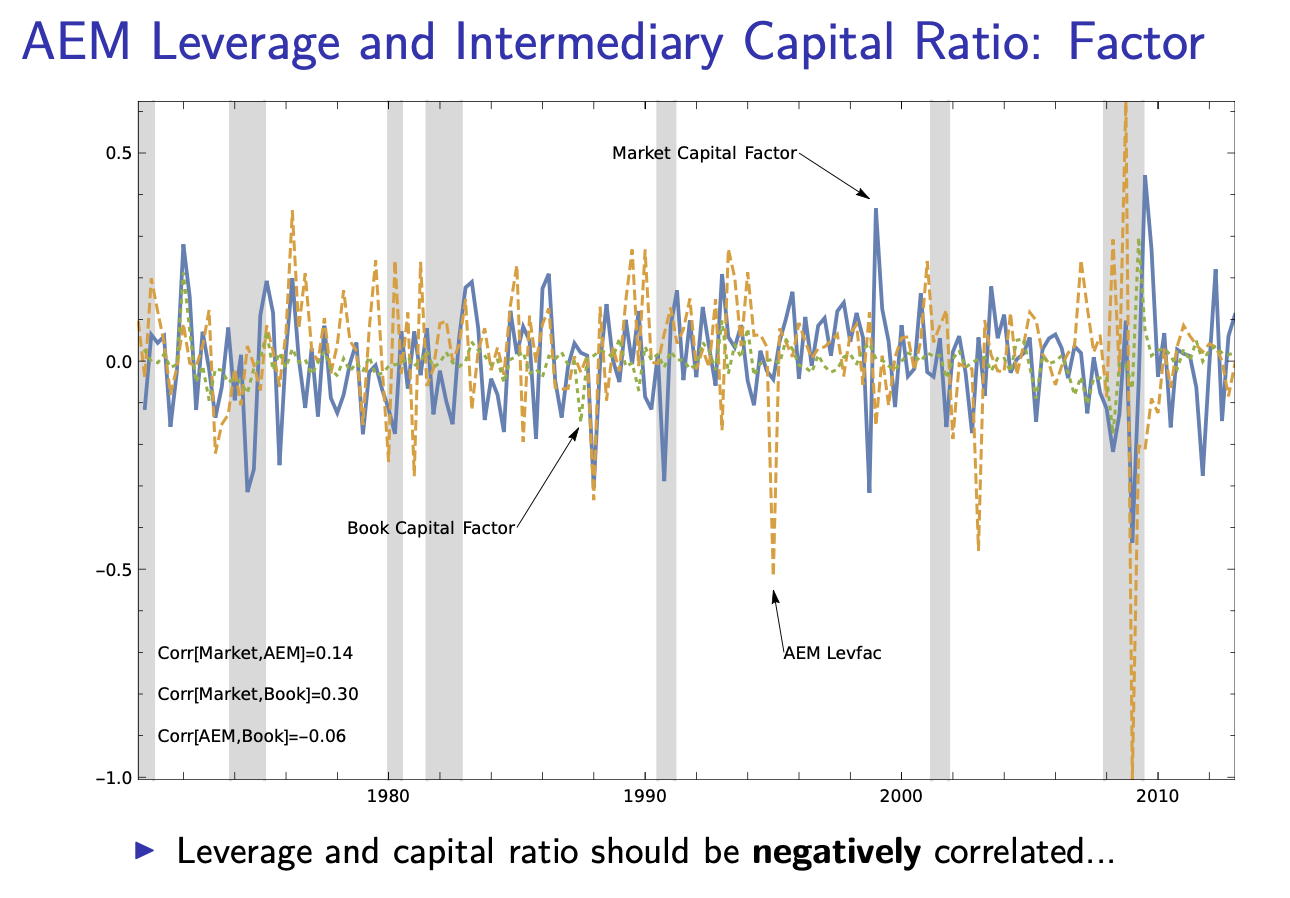

In [40]:
Image(filename='../data/AEM_factor.png', width=800)

----
# Macro Variables
## 1. E/P

## $\star$ $\star$ Issue: Shiller's E/P

In [41]:
# query = """
#         SELECT a.datadate, a.req, a.datafqtr, b.gvkey, b.iid , b.from, b.thru
#         FROM
#             comp.fundq a
#         INNER JOIN
#             comp.idxcst_his b ON a.gvkey = b.gvkey
#         WHERE
#             a.DATAFMT = 'STD' AND
#             a.INDFMT = 'INDL' AND
#             a.CONSOL = 'C' AND
#             a.POPSRC = 'D' AND
#             a.datadate >= b.from AND
#             (a.datadate <= b.thru OR b.thru IS NULL)
#         ORDER BY a.datadate;
#         """

# sp500_earnings = db.raw_sql(query)
# sp500_earnings

In [42]:
# use the data from the excel file
# the data is pulled from: https://shillerdata.com/
# https://img1.wsimg.com/blobby/go/e5e77e0b-59d1-44d9-ab25-4763ac982e53/downloads/ie_data.xls?ver=1709574707758

shiller_cape = pd.read_excel('Shiller_CAPE.xls', skiprows=9, usecols="A,M")
shiller_cape.columns = ['date', 'cape']

shiller_cape['date'] = shiller_cape['date'].astype(str)
shiller_cape['date'] = pd.to_datetime(shiller_cape['date'], format='%Y.%m') + pd.offsets.MonthEnd(0)

shiller_cape = shiller_cape[(shiller_cape['date'] >= '1970-01-01') & (shiller_cape['date'] <= '2012-12-31')]
shiller_cape = shiller_cape.set_index('date')

shiller_cape['e/p'] = 1 / shiller_cape['cape']
shiller_cape

,cape,e/p
date,,
1970-01-31,17.090541,0.058512
1970-02-28,16.372587,0.061078
1970-03-31,16.531691,0.060490
1970-04-30,15.873068,0.063000
1970-05-31,13.983836,0.071511
...,...,...
2012-08-31,21.410428,0.046706
2012-09-30,21.783690,0.045906
2012-01-31,21.577110,0.046345


## 2. Unemployment, GDP, Financial Conditions

In [43]:
macro_data

,unemp_rate,nfci,nom_gdp,real_gdp,real_gdp_growth,bd_fin_assets,bd_liabilities,aem_leverage,aem_leverage_ratio,leverage_growth,seasonal,aem_leverage_factor
DATE,,,,,,,,,,,,
1970-03-31,4.166667,NaN,1051.200,5300.652,-0.6,13071.0,12089.0,13.310591,0.075128,0.000000,-0.018367,0.018367
1970-06-30,4.766667,NaN,1067.375,5308.164,0.6,11741.0,10802.0,12.503727,0.079976,-0.060618,0.003523,-0.064141
1970-09-30,5.166667,NaN,1086.059,5357.077,3.7,13298.0,12384.0,14.549234,0.068732,0.163592,0.002614,0.160978
1970-12-31,5.833333,NaN,1088.608,5299.672,-4.2,16246.0,15340.0,17.931567,0.055768,0.232475,0.012230,0.220245
1971-03-31,5.933333,0.893634,1135.156,5443.619,11.3,14861.0,13923.0,15.843284,0.063118,-0.116459,-0.018367,-0.098092
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,3.500000,-0.257934,26813.601,22112.329,2.2,4803777.0,4501526.0,15.893337,0.062919,0.054408,-0.018367,0.072774
2023-06-30,3.566667,-0.231994,27063.012,22225.350,2.1,4809159.0,4504411.0,15.780773,0.063368,-0.007082,0.003523,-0.010605
2023-09-30,3.700000,-0.329642,27610.128,22490.692,4.9,4757062.0,4449712.0,15.477670,0.064609,-0.019207,0.002614,-0.021821


## 3. Market volatility

In [44]:
def pull_CRSP_Value_Weighted_Index():
    """
    Pulls a value-weighted stock index from the CRSP database.

    Returns:
    - pandas.DataFrame: DataFrame containing the value-weighted stock index data.

    Note:
    This function executes a SQL query to retrieve the value-weighted stock index data from CRSP. 
    The returned DataFrame includes columns for 'date' and 'vwretd' (value-weighted return including dividends).
    """
    
    sql_query = """
        SELECT date, vwretd
        FROM crsp.msi as msi
        WHERE msi.date >= '1970-01-01' AND msi.date <= '2012-12-31'
        """
    
    data = db.raw_sql(sql_query, date_cols=["date"])
    return data

In [45]:
value_wtd_indx = pull_CRSP_Value_Weighted_Index()

value_wtd_indx['date'] = pd.to_datetime(value_wtd_indx['date'])
value_wtd_indx.set_index('date', inplace=True)

value_wtd_indx['change'] = value_wtd_indx['vwretd'].pct_change()
volatility_by_quarter = value_wtd_indx['change'].groupby(pd.Grouper(freq='Q')).std()
annualized_volatility = volatility_by_quarter.rename('mkt_vol')
annualized_volatility

date
1970-03-31     0.488403
1970-06-30    12.452839
1970-09-30     1.314768
1970-12-31     2.000585
1971-03-31     1.216783
                ...    
2011-12-31     0.647398
2012-03-31     8.110201
2012-06-30     5.797123
2012-09-30     1.165194
2012-12-31     1.448625
Freq: Q-DEC, Name: mkt_vol, Length: 172, dtype: float64

## 4. Market excess return

In [46]:
import pandas_datareader.data as web

startdate = '19700101'
enddate = '20121231'

rawdata = web.DataReader('F-F_Research_Data_5_Factors_2x3', data_source='famafrench',start=startdate,end=enddate)
ff_facs = rawdata[0] / 100
# convert the yyyy-mm to timestamp object. default is to put first of month, but should be end of month
ff_facs = ff_facs.to_timestamp().resample('Q').last()
ff_facs.rename(columns={'Mkt-RF':'MKT'},inplace=True)
ff_facs.rename(columns={'MKT':'mkt_ret'},inplace=True)

ff_facs

/var/folders/hk/t7fnwnf568g5fqkjmc9d2vbr0000gn/T/ipykernel_51877/1823492543.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  rawdata = web.DataReader('F-F_Research_Data_5_Factors_2x3', data_source='famafrench',start=startdate,end=enddate)
/var/folders/hk/t7fnwnf568g5fqkjmc9d2vbr0000gn/T/ipykernel_51877/1823492543.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  rawdata = web.DataReader('F-F_Research_Data_5_Factors_2x3', data_source='famafrench',start=startdate,end=enddate)


,mkt_ret,SMB,HML,RMW,CMA,RF
Date,,,,,,
1970-03-31,-0.0106,-0.0241,0.0399,-0.0100,0.0429,0.0057
1970-06-30,-0.0579,-0.0220,0.0060,0.0013,0.0296,0.0058
1970-09-30,0.0418,0.0851,-0.0547,0.0030,-0.0583,0.0054
1970-12-31,0.0572,0.0294,0.0100,0.0027,0.0030,0.0042
1971-03-31,0.0413,0.0226,-0.0395,0.0182,-0.0271,0.0030
...,...,...,...,...,...,...
2011-12-31,0.0074,-0.0033,0.0163,0.0098,0.0252,0.0000
2012-03-31,0.0311,-0.0047,0.0114,-0.0054,0.0074,0.0000
2012-06-30,0.0389,0.0084,0.0062,-0.0109,0.0046,0.0000


In [47]:
macro_merged = shiller_cape[['e/p']].merge(macro_data[['unemp_rate', 'nfci', 'real_gdp']], left_index=True, right_index=True)
macro_merged = macro_merged.merge(ff_facs[['mkt_ret']],left_index=True, right_index=True)
macro_merged = macro_merged.merge(annualized_volatility, left_index=True, right_index=True)
macro_merged

,e/p,unemp_rate,nfci,real_gdp,mkt_ret,mkt_vol
date,,,,,,
1970-03-31,0.060490,4.166667,NaN,5300.652,-0.0106,0.488403
1970-06-30,0.072465,4.766667,NaN,5308.164,-0.0579,12.452839
1970-09-30,0.067373,5.166667,NaN,5357.077,0.0418,1.314768
1970-12-31,0.062997,5.833333,NaN,5299.672,0.0572,2.000585
1971-03-31,0.057462,5.933333,0.893634,5443.619,0.0413,1.216783
...,...,...,...,...,...,...
2011-12-31,0.048724,8.633333,-0.037502,17222.583,0.0074,0.647398
2012-03-31,0.045343,8.266667,-0.342313,17367.010,0.0311,8.110201
2012-06-30,0.048668,8.200000,-0.298552,17444.525,0.0389,5.797123


In [62]:
levels2 = levels.merge(macro_merged, left_index=True, right_index=True)
levels2.columns = ['Market capital', 'Book capital', 'AEM leverage', 
                    'E/P', 'Unemployment', 'Financial conditions', 'GDP', 'Market excess return', 'Market volatility']
levels2

,Market capital,Book capital,AEM leverage,E/P,Unemployment,Financial conditions,GDP,Market excess return,Market volatility
1974-03-31,0.078817,0.044556,6.602086,0.075129,5.133333,0.658415,6097.258,-0.0281,6.017553
1974-06-30,0.040215,0.040167,6.520717,0.084115,5.200000,2.803538,6111.751,-0.0283,0.737496
1974-09-30,0.023982,0.040324,6.086532,0.115202,5.633333,4.631018,6053.978,-0.1177,1.065251
1974-12-31,0.027051,0.047749,6.165203,0.120641,6.600000,2.866296,6030.464,-0.0345,1.088398
1975-03-31,0.036932,0.051134,5.461659,0.098388,8.266667,1.242130,5957.035,0.0266,3.296001
...,...,...,...,...,...,...,...,...,...
2011-12-31,0.028728,0.044690,24.745237,0.048724,8.633333,-0.037502,17222.583,0.0074,0.647398
2012-03-31,0.041701,0.045511,24.059559,0.045343,8.266667,-0.342313,17367.010,0.0311,8.110201
2012-06-30,0.029645,0.044725,24.093422,0.048668,8.200000,-0.298552,17444.525,0.0389,5.797123
2012-09-30,0.032123,0.045213,22.513054,0.045906,8.033333,-0.399320,17469.650,0.0273,1.165194


In [63]:
macro_merged_2 = np.log(macro_merged / macro_merged.shift(1))
macro_merged_2

/Users/youmjaehwa/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,e/p,unemp_rate,nfci,real_gdp,mkt_ret,mkt_vol
date,,,,,,
1970-03-31,NaN,NaN,NaN,NaN,NaN,NaN
1970-06-30,0.180633,0.134531,NaN,0.001416,1.697863,3.238563
1970-09-30,-0.072859,0.080580,NaN,0.009172,NaN,-2.248289
1970-12-31,-0.067167,0.121361,NaN,-0.010774,0.313658,0.419780
1971-03-31,-0.091964,0.016998,NaN,0.026799,-0.325691,-0.497229
...,...,...,...,...,...,...
2011-12-31,-0.041051,-0.041594,-1.850894,0.011168,NaN,-0.088938
2012-03-31,-0.071917,-0.043399,2.211344,0.008351,1.435728,2.527916
2012-06-30,0.070752,-0.008097,-0.136783,0.004453,0.223786,-0.335761


In [64]:
factors2 = factors.merge(macro_merged_2, left_index=True, right_index=True)
factors2.columns = ['Market capital factor', 'Book capital factor', 'AEM leverage factor', 
                    'E/P growth', 'Unemployment growth', 'Financial conditions growth', 'GDP growth', 'Market excess return', 'Market volatility growth']
factors2

,Market capital factor,Book capital factor,AEM leverage factor,E/P growth,Unemployment growth,Financial conditions growth,GDP growth,Market excess return,Market volatility growth
1974-03-31,NaN,NaN,-0.219260,0.013652,0.074108,-1.069749,-0.008634,NaN,-3.329082
1974-06-30,-0.421167,-0.105252,-0.025688,0.112972,0.012903,1.448802,0.002374,0.007092,-2.099175
1974-09-30,-0.460081,-0.047587,-0.069594,0.314501,0.080043,0.501894,-0.009498,1.425277,0.367704
1974-12-31,-0.101278,0.134393,-0.035557,0.046133,0.158368,-0.479756,-0.003892,-1.227180,0.021496
1975-03-31,0.184606,0.091558,-0.050791,-0.203895,0.225162,-0.836193,-0.012251,NaN,1.108003
...,...,...,...,...,...,...,...,...,...
2011-12-31,-0.200360,0.024299,0.010416,-0.041051,-0.041594,-1.850894,0.011168,NaN,-0.088938
2012-03-31,0.293050,0.012864,0.007403,-0.071917,-0.043399,2.211344,0.008351,1.435728,2.527916
2012-06-30,-0.336439,-0.015418,-0.009609,0.070752,-0.008097,-0.136783,0.004453,0.223786,-0.335761
2012-09-30,-0.063866,0.005732,-0.026296,-0.058422,-0.020535,0.290821,0.001439,-0.354108,-1.604474


# Final Output

## Panel A

In [74]:
correlation_panelA = levels2.iloc[:,:3].corr()
correlation_panelA

,Market capital,Book capital,AEM leverage
Market capital,1.000000,0.205130,0.489611
Book capital,0.205130,1.000000,-0.174383
AEM leverage,0.489611,-0.174383,1.000000


## $\star$ $\star$ Issue: Not sure whether it is GDP level itself

In [78]:
main_cols = levels2[['Market capital', 'Book capital', 'AEM leverage']]
other_cols = levels2[['E/P', 'Unemployment', 'GDP', 'Financial conditions', 'Market volatility']]

correlation_results_panelA = pd.DataFrame(index=main_cols.columns)

for column in other_cols.columns:
    correlation_results_panelA[column] = main_cols.corrwith(other_cols[column])

correlation_results_panelA.T

,Market capital,Book capital,AEM leverage
E/P,-0.650200,-0.188186,-0.720724
Unemployment,-0.513139,0.065918,-0.405832
GDP,0.383679,-0.155815,0.837514
Financial conditions,-0.396235,-0.370875,-0.337289
Market volatility,-0.116979,0.001073,-0.130774


In [79]:
pd.concat([correlation_panelA, correlation_results_panelA.T], axis=0)

,Market capital,Book capital,AEM leverage
Market capital,1.000000,0.205130,0.489611
Book capital,0.205130,1.000000,-0.174383
AEM leverage,0.489611,-0.174383,1.000000
E/P,-0.650200,-0.188186,-0.720724
Unemployment,-0.513139,0.065918,-0.405832
GDP,0.383679,-0.155815,0.837514
Financial conditions,-0.396235,-0.370875,-0.337289
Market volatility,-0.116979,0.001073,-0.130774


## Panel B

In [75]:
# get the correlation of factors
correlation_panelB = factors2.iloc[:,:3].corr()
correlation_panelB

,Market capital factor,Book capital factor,AEM leverage factor
Market capital factor,1.000000,0.303104,0.027419
Book capital factor,0.303104,1.000000,0.040450
AEM leverage factor,0.027419,0.040450,1.000000


In [76]:
main_cols = factors2[['Market capital factor', 'Book capital factor', 'AEM leverage factor']]
other_cols = factors2[['Market excess return', 'E/P growth', 'Unemployment growth', 'GDP growth', 'Financial conditions growth', 'Market volatility growth']]

correlation_results_panelB = pd.DataFrame(index=main_cols.columns)

for column in other_cols.columns:
    correlation_results_panelB[column] = main_cols.corrwith(other_cols[column])
    
correlation_results_panelB.T

,Market capital factor,Book capital factor,AEM leverage factor
Market excess return,-0.083635,0.142961,-0.017795
E/P growth,-0.415337,-0.194443,-0.153490
Unemployment growth,-0.030898,0.005261,-0.227884
GDP growth,0.068433,0.147096,0.167536
Financial conditions growth,-0.098692,-0.037932,0.056038
Market volatility growth,0.186485,0.226515,0.153105


In [77]:
pd.concat([correlation_panelB, correlation_results_panelB.T], axis=0)

,Market capital factor,Book capital factor,AEM leverage factor
Market capital factor,1.000000,0.303104,0.027419
Book capital factor,0.303104,1.000000,0.040450
AEM leverage factor,0.027419,0.040450,1.000000
Market excess return,-0.083635,0.142961,-0.017795
E/P growth,-0.415337,-0.194443,-0.153490
Unemployment growth,-0.030898,0.005261,-0.227884
GDP growth,0.068433,0.147096,0.167536
Financial conditions growth,-0.098692,-0.037932,0.056038
Market volatility growth,0.186485,0.226515,0.153105
